# `LynneSim`: A Simple Tool to Investigate Trading LSST Survey Area and Depth

<br>Owner(s): **Phil Marshall** ([@drphilmarshall](https://github.com/LSSTScienceCollaborations/survey_strategy_wp/issues/new?body=@drphilamrshall))
<br>Last Verified to Run: **2018-09-19**

Teams writing white papers may well need to make rough estimates of the cost of various high level decisions that could be taken about the LSST observing strategy, such as how deep to go in various sky regions. `LynneSim` is a simple tool to enable such calculations.

### Learning Objectives:

After working through this tutorial you should be able to use `LynneSim` to emulate (very approximately) an OpSim run followed by a (very basic) MAF analysis.

### Logistics
This notebook is intended to be runnable anywhere, with only standard dependencies.

## Set-up

In [192]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Getting Started

Suppose we want to know how many visits per field, and hence the 5-sigma depth, we could get, if we put the standard number of visits in the usual WFD region, and then split the remainder over the rest of our "big sky" (-90 to +32 deg) - and don't do any DDFs or mini-surveys at all. One way to answer this question is to ask Lynne Jones to configure and run OpSim, and then do a MAF analysis. We can get an approximate answer with a very simple emulator of Lynne Jones.

In [265]:
class LynneSim(object):
    """
    Worker class for estimating approximate LSST depth etc in a mock proposal-based LSST survey campaign.
    """
    def __init__(self):
        # Set some constants:
        self.totalNvis = 2600000  # without snaps (1x30s/visit)
        # Let's say we can play with 90% of these visits
        self.percentTotal = 0.90
        self.Nvisits = self.totalNvis * self.percentTotal
        print("The number of visits available is %d (%.2fM)" % (self.Nvisits, self.Nvisits/1000000))
        # Read in available fields
        self.fields = pd.read_csv('field_list.csv')
        # Prepare to define survey regions
        self.regions = {}
        self.NvisitsPerField = {}
        self.fractions = {}
        return
    
    def define_survey_region(self, name, limits=None, NvisitsPerField=None, fractions=None):
        """
        Extract a subset of the fields, within the given spatial limits.
        
        Parameters
        ==========
        name: string
            The name of the survey region being specified
        limits: dict
            Limits in ra/dec, galactic b/l and/or ecliptic b/l that define the survey region
        """
        if limits is None:
            limits = {'ra':[0.0,360.0], 'dec':[-90,90], 'gl':[0.0,360.0], 'gb':[-90.0,90.0], 'el':[0.0,360.0], 'eb':[-90.0,90.0]}
        if fractions is None:
            onesixth = 1.0/6.0
            self.fractions[name] = {'u':onesixth, 'g':onesixth, 'r':onesixth, 'i':onesixth, 'z':onesixth, 'y':onesixth}
        self.NvisitsPerField[name] = NvisitsPerField
        
        subset = self.fields
        for coord in limits.keys():
            xmin, xmax = limits[coord][0], limits[coord][1]
            if xmax > xmin: 
                plus = 'and'
            else:
                plus = 'or'
            in_this_range = "({x} >= {xmin}) {and_or} ({x} <= {xmax})".format(x=coord, xmin=xmin, and_or=plus, xmax=xmax)
            subset = subset.query(in_this_range)
        self.regions[name] = subset
        
        print("The number of fields in the {0} footprint is {1:d}".format(name, len(subset)))

        return
        
    def calculate_metrics(self):
        """
        Compute Nvis and depth per field.
        """
        # Loop over defined regions, computing number of visits, and depth, in each field.
        count = 0
        the_rest = []
        fields_remaining = 0
        for name in self.regions.keys():
            Nfields = len(self.regions[name])
            if self.NvisitsPerField[name] is not None:
                new_column = pd.DataFrame({'Nvis': np.ones(Nfields)*self.NvisitsPerField[name]})
                self.regions[name] = self.regions[name].join(new_column)
                this_many = int(np.sum(self.regions[name].Nvis))
                print(this_many," visits allocated to region ", name)
                print(self.NvisitsPerField[name]," visits per ",name," field")
                count += this_many
            else:
                the_rest.append(name)
                fields_remaining += Nfields        
        remainder = int(self.Nvisits - count)
        print("Distributing ",remainder," visits among the remaining regions: ",the_rest)
        
        thisManyVisitsPerField = int(remainder / fields_remaining)
        for name in the_rest:
            Nfields = len(self.regions[name])
            self.NvisitsPerField[name] = thisManyVisitsPerField
            new_column = pd.DataFrame({'Nvis': np.ones(Nfields)*self.NvisitsPerField[name]})
            self.regions[name] = self.regions[name].join(new_column)
            this_many = int(np.sum(self.regions[name].Nvis))
            print(this_many," visits allocated to region ", name)
            print(self.NvisitsPerField[name]," visits per ",name," field")
        
        # All fields in all regions now have an Nvis value.
        
        return
        
    def plot_sky_map(self, metric=None):
        """
        Plot the desired metric as a sky map.
        
        Parameters
        ==========
        metric: string
            Name of the metric to be plotted [Nvis, depth]
        """
        if metric is None: 
            pass # Just plot locations, no grayscale for metric.
        
        fig = plt.figure(figsize=(8, 8))
        ax = plt.subplot(111, projection="aitoff")
        for name in self.regions.keys():
            x, y = radec2project(self.regions[name].ra, self.regions[name].dec)
            if metric is None:
                ax.scatter(x, y, alpha=0.7, label=name) # Marker color is assigned automatically
            else:
                if metric == 'Nvis':
                    z = self.regions[name].Nvis
                else:
                    raise ValueError("unrecognized metric {}".format(metric))
                s = ax.scatter(x, y, c=z, cmap='viridis')
                s.set_clim([0,1000])
        plt.grid(True)
        if metric is None: 
            plt.legend()
        else:
            plt.colorbar(s, orientation='horizontal')
        return


def radec2project(ra, dec):
    return (np.radians(ra) - np.pi, np.radians(dec))

In [266]:
Lynne = LynneSim()

The number of visits available is 2340000 (2.34M)


In [267]:
Lynne.fields[0:5]

,fieldId,fov,ra,dec,gl,gb,el,eb
0,1,3.5,0.000000,-90.000000,-57.068082,-27.128251,-89.931210,-66.561358
1,2,3.5,180.000000,-87.568555,-57.663825,-24.756541,-96.024547,-66.442665
2,3,3.5,324.000429,-87.568550,-54.980423,-28.712449,-85.262622,-65.058907
3,4,3.5,35.999571,-87.568550,-58.164147,-29.359810,-84.695237,-67.907706
4,5,3.5,252.001105,-87.568547,-54.748581,-25.862125,-91.659618,-64.238559


In [268]:
Lynne.define_survey_region('WFD', NvisitsPerField=825, limits={'dec':[-72.25,12.4], 'gb':[15.0,-15.0]})
Lynne.define_survey_region('GalacticPlane', limits={'gb':[-15.0,15.0], 'gl':[-180.0,180.0], 'dec':[-90.0,12.4]})

The number of fields in the WFD footprint is 2290
The number of fields in the GalacticPlane footprint is 798


In [269]:
Lynne.calculate_metrics()

1282875  visits allocated to region  WFD
825  visits per  WFD  field
Distributing  1057125  visits among the remaining regions:  ['GalacticPlane']
368072  visits allocated to region  GalacticPlane
1324  visits per  GalacticPlane  field


In [262]:
Lynne.regions['GalacticPlane'][0:5]

,fieldId,fov,ra,dec,gl,gb,el,eb,Nvis
67,68,3.5,193.206897,-77.535325,-56.990572,-14.663785,-115.784993,-61.192813,1324.0
71,72,3.5,180.000000,-76.461360,-60.144794,-13.897841,-121.120283,-63.124626,1324.0
76,77,3.5,215.999990,-75.741972,-51.345487,-13.908912,-110.958446,-56.267797,1324.0
81,82,3.5,203.037810,-75.516238,-54.469851,-12.850270,-115.787081,-58.146028,1324.0
91,92,3.5,190.840031,-74.831653,-57.608121,-11.968375,-120.851045,-59.991241,1324.0


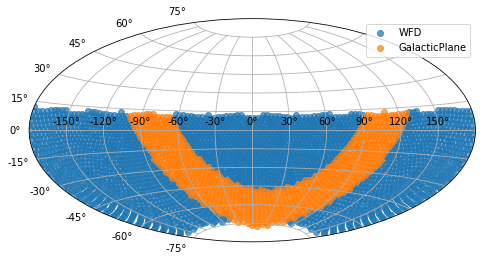

In [263]:
Lynne.plot_sky_map()

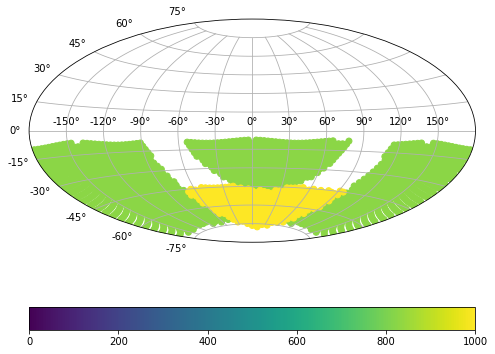

In [264]:
Lynne.plot_sky_map(metric='Nvis')

----

## Old Notebook Code

So how many visits could we potentially have per field: if we sent 825 visits/field to WFD and then split the rest among the other fields?

In [274]:
wfdvisits = len(wfd) * 825
print("Reserving %d visits for WFD" % (wfdvisits))
availNvis = totalNvis - wfdvisits
print("Available visits for other surveys: %d (%.2fM)" % (availNvis, availNvis/1000000))
# Exact number of visits per field
visPerField = availNvis / len(bigNotWFD)
# Round the number of visits per field to an integer
visPerField = int(round(visPerField))
# And recalculate what this means for the totalNvis -- if the total # changed too much, maybe round down
propTotal = visPerField * len(bigNotWFD)
print("This corresponds to %d visits per field (%.2f/year)" % (visPerField, (visPerField/10.)))
print("This implies a total number of visits required of %d (compared to original estimate of %d): %.2f%s change"
     % (propTotal + wfdvisits, totalNvis, float(propTotal + wfdvisits - totalNvis) / totalNvis * 100.0, "%"))
print("Ratio WFD (%.2fM) to (all) total visits (%.2fM): %.2f" % (wfdvisits/1000000, 
                                                                 totalNvis/percentTotal/1000000,
                                                                 wfdvisits/(totalNvis/percentTotal)))


In [12]:
# visits per month (assume season = 5 months /year) per year (assume 8 years 'on')
visPerField/5/10

5.08

Let's add some estimate on the coadded depths you could achieve.

This requires assuming a dark sky, zenith, typical single visit depth and then scaling by the number of visits in each filter. 

In [13]:
# Current expected performance
single_m5 = {'u': 23.98, 'g': 24.91, 'r': 24.42, 'i': 23.97, 'z': 23.38, 'y': 22.47}

In [36]:
# How should we divide the visits? (per field) 
fractionsPerFilter = {'u': 0.1, 'g': 0.1, 'r': 0.20, 'i': 0.20, 'z': 0.20, 'y': 0.20}
fracSum = 0
for f, v in fractionsPerFilter.items():
    fracSum += v
    print('Fraction in %s: %.3f' % (f, v))
print("Total: %.3f" % (fracSum))

Fraction in u: 0.100
Fraction in g: 0.100
Fraction in r: 0.200
Fraction in i: 0.200
Fraction in z: 0.200
Fraction in y: 0.200
Total: 1.000


In [38]:
# Make actual numbers per filter .. jiggle as necessary. (note that you could set these by hand instead)
visPerFilter = {}
fieldTotal = 0
for f in fractionsPerFilter:
    visPerFilter[f] = int(round(fractionsPerFilter[f] * visPerField))
    fieldTotal += visPerFilter[f]
    print('Visits in %s: %d' % (f, visPerFilter[f]))
print('Total per field: %d (compared to potential %d per field previously calculated)' %(fieldTotal, visPerField))
# Jiggle by hand ..
visPerFilter['r'] += 0
fieldTotal = 0
for f in visPerFilter:
    fieldTotal += visPerFilter[f]
    print('Visits in %s: %d' % (f, visPerFilter[f]))
print('After re-jiggering: Total per field: %d (compared to potential %d per field previously calculated)' %(fieldTotal, visPerField))

Visits in u: 25
Visits in g: 25
Visits in r: 51
Visits in i: 51
Visits in z: 51
Visits in y: 51
Total per field: 254 (compared to potential 254 per field previously calculated)
Visits in u: 25
Visits in g: 25
Visits in r: 51
Visits in i: 51
Visits in z: 51
Visits in y: 51
After re-jiggering: Total per field: 254 (compared to potential 254 per field previously calculated)


So calculate the scaled coadded depth per filter, per field. Note that this assumes all observations are taken under the same "dark-sky, zenith" conditions.

In [39]:
# Current expected performance
single_m5 = {'u': 23.98, 'g': 24.91, 'r': 24.42, 'i': 23.97, 'z': 23.38, 'y': 22.47}

In [40]:
coadd_m5 = {}
for f in visPerFilter:
    coadd_m5[f] = single_m5[f] + 2.5 * np.log10(np.sqrt(visPerFilter[f]))
    print("Coadded depth in %s: %.2f" % (f, coadd_m5[f]))

Coadded depth in u: 25.73
Coadded depth in g: 26.66
Coadded depth in r: 26.55
Coadded depth in i: 26.10
Coadded depth in z: 25.51
Coadded depth in y: 24.60


Given "realistic" opsim conditions, we would expect some typical offsets from these dark-sky, zenith coadded depths. 
Using the WFD region from kraken\_2026 we can calculate these expected offsets:

In [41]:
# Using estimates from kraken_2026:
kraken_single_m5 = {'u': 23.78, 'g': 24.81, 'r': 24.35, 'i': 23.92, 'z': 23.34, 'y': 22.45}
kraken_visPerFilter = {'u': 64, 'g': 90, 'r': 206, 'i': 204, 'z': 186, 'y': 188}
opsimCoaddM5 = {'u': 25.65, 'g': 27.15, 'r': 27.20, 'i': 26.62, 'z': 25.72, 'y': 24.91}
kraken_coadd_m5 = {}
offset = {}
for f in visPerFilter:
    kraken_coadd_m5[f] = kraken_single_m5[f] + 2.5 * np.log10(np.sqrt(kraken_visPerFilter[f]))
    offset[f] = kraken_coadd_m5[f] - opsimCoaddM5[f]
    print("Coadded depth in %s: %.2f - correction is %.2f" % (f, kraken_coadd_m5[f], offset[f]))

Coadded depth in u: 26.04 - correction is 0.39
Coadded depth in g: 27.25 - correction is 0.10
Coadded depth in r: 27.24 - correction is 0.04
Coadded depth in i: 26.81 - correction is 0.19
Coadded depth in z: 26.18 - correction is 0.46
Coadded depth in y: 25.29 - correction is 0.38


In [42]:
saved_offsets = {'u': 0.39, 'g': 0.10, 'r': 0.04, 'i': 0.19, 'z': 0.46, 'y': 0.38}

In [43]:
# Means we might achieve these coadded values:
for f in visPerFilter:
    coadd_m5[f] = single_m5[f] + 2.5 * np.log10(np.sqrt(visPerFilter[f])) - saved_offsets[f]
    print("Coadded depth in %s: %.2f" % (f, coadd_m5[f]))

Coadded depth in u: 25.34
Coadded depth in g: 26.56
Coadded depth in r: 26.51
Coadded depth in i: 25.91
Coadded depth in z: 25.05
Coadded depth in y: 24.22
